In [340]:
import BenchmarkTools: @btime, @benchmark;

import Pkg: activate, build
activate("../GSHEIntegrator/.")
import GSHEIntegrator;


import Plots
using LaTeXStrings
using Measures
using NPZ
using EllipsisNotation

  Activating project at `~/code/GSHE/GSHEIntegrator`


## Compute individual trajectories

In [152]:
using Dates

function generate_filename(base::String="GSHE", counter::Int=0)
    """
    generate_filename(base::String="trajectory", counter::Int=0)

    Generate a unique filename based on the current date and time.

    # Arguments
    - `base::String="trajectory"`: The base name for the file.
    - `counter::Int=0`: Counter to append to the filename if a file with the same name already exists.

    # Returns
    - `String`: A unique filename in the format of `base_date_time[_counter].jld2`

    # Examples
    ```julia
    generate_filename()  # Returns "GSHE_2023_10_03_14_30_00"
    generate_filename("experiment", 1)  # Returns "experiment_2023_10_03_14_30_01"
    """
    date_str = Dates.format(now(), "yyyy_mm_dd")
    time_str = Dates.format(now(), "HH_MM_SS")
    
    filename = "$(base)_$(date_str)_$(time_str)"
    
    # Check if file exists, if yes, append counter
    if isfile("$(filename).jld2") || counter > 0
        filename *= "_$(counter)"
    end
    
    # Increment counter if file with that name exists
    while isfile("$(filename).jld2")
        counter += 1
        filename = "$(base)_$(date_str)_$(time_str)_$(counter)"
    end
    
    return "$(filename)"
end

generate_filename (generic function with 3 methods)

Setup the problem geometry

In [182]:
Nsols = 2

# Solve at this many epsilon steps!
ϵs = (10).^LinRange(-3, -1, 10)

geometry = GSHEIntegrator.setup_geometry(
   rsource=5, θsource=0.5π, ϕsource=0.0π,
   robs=25, θobs=0.01π, ϕobs=-π,
   a=0.99)

GSHEIntegrator.Geometry{Float64}
  dtype: Float64 <: AbstractFloat
  source: GSHEIntegrator.SphericalCoords{Float64}
  observer: GSHEIntegrator.SphericalCoords{Float64}
  direction_coords: Symbol spherical
  getmagnification: Bool false
  s: Int64 2
  a: Float64 0.99
  arrival_time: Float64 0.0
  redshift: Float64 0.0
  nloops: Float64 0.0
  ϕkilling: Float64 0.0
  ode_options: GSHEIntegrator.ODESolverOptions
  opt_options: GSHEIntegrator.OptimiserOptions
  postproc_options: GSHEIntegrator.PostprocOptions


Solve a geodesic/GSHE trajectory in pointing in an initial direction $\psi=0.2, \rho=0.3$

In [198]:
p0 = [-1, 0.3]
geodesic_sol = GSHEIntegrator.solve_problem(p0, geometry, 0, 2; save_everystep=true)
# GSHE at ϵ=0.1 for s=2
gshe_sol = GSHEIntegrator.solve_problem(p0, geometry, 0.1, 2; save_everystep=true);

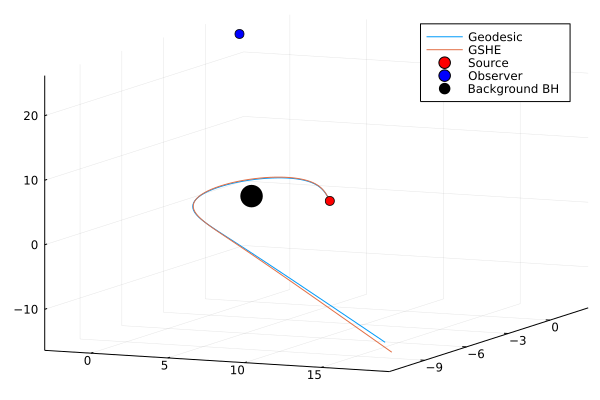

In [199]:
transform(x::Vector{<:Real}) = GSHEIntegrator.spherical_to_cartesian(x, geometry.a)
geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
gshe_trajectory = mapslices(transform, gshe_sol[2:4, :], dims=1)

fig = Plots.plot()
Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic")
Plots.plot!(fig, [gshe_trajectory[i, :] for i in 1:3]..., label="GSHE")

GSHEIntegrator.plot_start_end!(fig, geometry)
GSHEIntegrator.plotbh!(fig)

Arrival timing to the observer

In [185]:
# Each row contains ψ, ρ, t, z, Δσmin, nloops
Xgeo = GSHEIntegrator.solve_initial(geometry, 0.0, Nsols)

2×9 Matrix{Float64}:
 1.46868  4.92262  29.0986  1.23836  1.19264e-14  0.0   0.014864   1.0  NaN
 1.48947  2.22882  46.3218  1.23836  2.0466e-14   0.0  -0.0919687  1.0  NaN

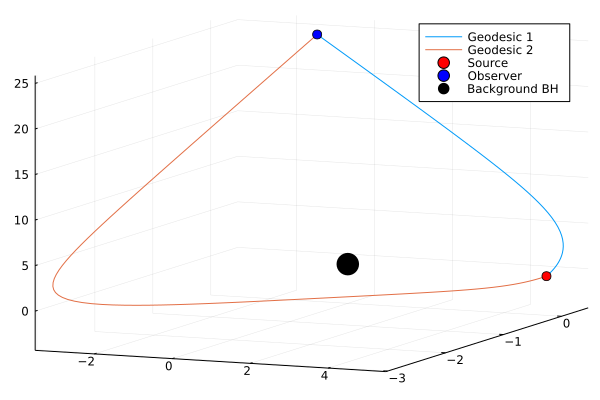

In [200]:
fig = Plots.plot()
for i in 1:2
    geodesic_sol = GSHEIntegrator.solve_problem(Xgeo[i, 1:2], geometry, 0, 2; save_everystep=true)
    geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
    Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic $i")
end
GSHEIntegrator.plot_start_end!(fig, geometry)
GSHEIntegrator.plotbh!(fig)
display(fig)

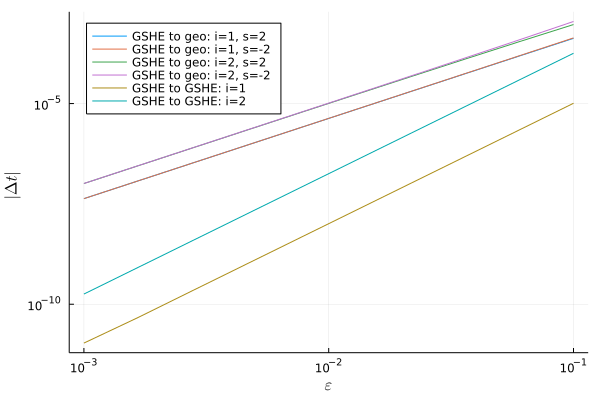

In [187]:
# Each row contains ψ, ρ, t, z, Δσmin, nloops
# Xgeo = GSHEIntegrator.solve_initial(geometry, 0.0, Nsols)
# Shape is  (Nsols, s = ± 2, Nϵs, 6). Last index same as above
Xgshe = GSHEIntegrator.solve_increasing(Xgeo, geometry, ϵs; verbose=false);


fig = Plots.plot(xlabel=L"\epsilon", ylabel=L"|\Delta t|", scale=:log10, yscale=:log10, legend=:topleft)
for i in 1:Nsols, (s, slabel) in enumerate([2, -2])
    dt = abs.(Xgshe[i,  s, :, 3] .- Xgeo[i, 3])
    Plots.plot!(fig, ϵs, dt, label="GSHE to geo: i=$i, s=$slabel")
end

for i in 1:Nsols
    dt = abs.(Xgshe[i,  1, :, 3] .- Xgshe[i, 2, :, 3])
    Plots.plot!(fig, ϵs, dt, label="GSHE to GSHE: i=$i")
end

display(fig)

In [216]:
Xgeo

2×9 Matrix{Float64}:
 1.46868  4.92262  29.0986  1.23836  1.19264e-14  0.0   0.014864   1.0  NaN
 1.48947  2.22882  46.3218  1.23836  2.0466e-14   0.0  -0.0919687  1.0  NaN

In [264]:
Xgshe[1,1,1,:]./Xgshe[2,1,1,:]

9-element Vector{Float64}:
   0.9856998838828468
   2.2089248875244145
   0.6281831401323182
   0.999953486441353
  10.61469134334352
 NaN
  -0.11460045745561685
   0.3333333333333333
 NaN

In [263]:
Xgshe[1,1,1,:]

9-element Vector{Float64}:
   1.4687678303955254
   4.922621082620244
  29.098587262394513
   1.2383303877201666
   1.0565375798971655e-13
   0.0
   0.010986657013017228
   1.0
 NaN

In [252]:
plotly()

fig = Plots.plot()
for i in 1:2
    geodesic_sol = GSHEIntegrator.solve_problem(Xgeo[i, 1:2], geometry, 0, 2; save_everystep=true)
    geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
    Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic $i")
    
    for (j,ϵ) in enumerate(ϵs)
#         println("$i, $ϵ")
        for k in [1,2]
            gshe_sol = GSHEIntegrator.solve_problem(Xgshe[i,k,j, 1:2], geometry, 0, 2; save_everystep=true)
             gshe_trajectory = mapslices(transform, gshe_sol[2:4, :], dims=1)
            Plots.plot!(fig, [gshe_trajectory[i, :] for i in 1:3]...,label=nothing)
        end
    end
   
end
GSHEIntegrator.plot_start_end!(fig, geometry)
GSHEIntegrator.plotbh!(fig)
display(fig)

In [248]:
using Pkg
Pkg.add("PlotlyBase")

   Resolving package versions...
   Installed PlotlyBase ─ v0.8.19
    Updating `~/code/GSHE/GSHEIntegrator/Project.toml`
  [a03496cd] + PlotlyBase v0.8.19
    Updating `~/code/GSHE/GSHEIntegrator/Manifest.toml`
  [a03496cd] + PlotlyBase v0.8.19
Precompiling project...
  ✓ PlotlyBase
  ✓ GSHEIntegrator
  2 dependencies successfully precompiled in 23 seconds (250 already precompiled)
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


In [190]:
# transform(x::Vector{<:Real}) = GSHEIntegrator.spherical_to_cartesian(x, geometry.a)
# geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
# gshe_trajectory = mapslices(transform, gshe_sol[2:4, :], dims=1)

# fig = Plots.plot()
# Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic")
# Plots.plot!(fig, [gshe_trajectory[i, :] for i in 1:3]..., label="GSHE")

In [201]:
αs, βs = GSHEIntegrator.fit_timing(ϵs, Xgeo, Xgshe, geometry; fit_gshe_gshe=true);
println("αs and βs, rows solutions and columns GSHE to GEO, GSHE to GEO and GSHE to GSHE")
flush(stdout)

display(αs[..,1])
display(βs[..,1])

αs and βs, rows solutions and columns GSHE to GEO, GSHE to GEO and GSHE to GSHE


2×3 Matrix{Float64}:
 1.99795  2.00214  2.99506
 1.98457  2.01557  2.9999

2×3 Matrix{Float64}:
 0.0422383  0.0433   0.0099852
 0.0930454  0.11178  0.17918

In [202]:
Xgeo

2×9 Matrix{Float64}:
 1.46868  4.92262  29.0986  1.23836  1.19264e-14  0.0   0.014864   1.0  NaN
 1.48947  2.22882  46.3218  1.23836  2.0466e-14   0.0  -0.0919687  1.0  NaN

In [181]:
filename = "../data/trajectories/"*generate_filename()

using Plots
gr()

fig = Plots.plot()
for i in 1:2
    geodesic_sol = GSHEIntegrator.solve_problem(Xgeo[i, 1:2], geometry, 0, 2; save_everystep=true)
    geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
    Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic $i")
end
GSHEIntegrator.plot_start_end!(fig, geometry)
GSHEIntegrator.plotbh!(fig)

savefig(fig, filename*".png")

using JLD2

@save filename*".jld2" geometry Xgeo Xgshe αs βs

In [316]:
#this would be load like this
@load "../data/trajectories/GSHE_2023_10_03_17_49_14.jld2"
Xgeo
geometry

GSHEIntegrator.Geometry{Float64}
  dtype: Float64 <: AbstractFloat
  source: GSHEIntegrator.SphericalCoords{Float64}
  observer: GSHEIntegrator.SphericalCoords{Float64}
  direction_coords: Symbol spherical
  getmagnification: Bool false
  s: Int64 2
  a: Float64 0.99
  arrival_time: Float64 48.880443355140734
  redshift: Float64 1.2325154676869772
  nloops: Float64 0.0
  ϕkilling: Float64 -1.5897579963070156
  ode_options: GSHEIntegrator.ODESolverOptions
  opt_options: GSHEIntegrator.OptimiserOptions
  postproc_options: GSHEIntegrator.PostprocOptions


## Map the observer positions

In [342]:
ϕs = [1.1π] #collect(range(0.0,stop=2π,length=3))[1:end-1]

# Solve at this many epsilon steps!
ϵs = (10).^LinRange(-3, -1, 10)

Nsols = 2

rsource=5
θsource=0.5π
ϕsource=0
robs=25
θobs=0.5π
ϕobs=-π
akerr=0.99

geometry = GSHEIntegrator.setup_geometry(
   rsource=rsource, θsource=θsource, ϕsource=ϕsource,
   robs=robs, θobs=θobs, ϕobs=ϕobs,
   a=akerr)

GSHEIntegrator.Geometry{Float64}
  dtype: Float64 <: AbstractFloat
  source: GSHEIntegrator.SphericalCoords{Float64}
  observer: GSHEIntegrator.SphericalCoords{Float64}
  direction_coords: Symbol spherical
  getmagnification: Bool false
  s: Int64 2
  a: Float64 0.99
  arrival_time: Float64 0.0
  redshift: Float64 0.0
  nloops: Float64 0.0
  ϕkilling: Float64 0.0
  ode_options: GSHEIntegrator.ODESolverOptions
  opt_options: GSHEIntegrator.OptimiserOptions
  postproc_options: GSHEIntegrator.PostprocOptions


In [343]:
#compute only 2 trajectories and infer beta, betaLR from them
ϵ0 = 1e-3

for ϕ in ϕs
    geometry = GSHEIntegrator.setup_geometry(
       rsource=rsource, θsource=θsource, ϕsource=ϕsource,
       robs=robs, θobs=θobs, ϕobs=ϕ,
       a=akerr)
    # Each row contains ψ, ρ, t, z, Δσmin, nloops
    Xgeo = GSHEIntegrator.solve_initial(geometry, 0.0, Nsols)
    # Shape is  (Nsols, s = ± 2, Nϵs, 6). Last index same as above
    Xeps = GSHEIntegrator.solve_initial(geometry, ϵ0, Nsols)
    println("ϕ   =",ϕ)
    println("μ   =",Xgeo[:,7])
    println("Δt  = ",Xgeo[2,3]-Xgeo[1,3])
    println("β   =",(Xgeo[:,3]-Xeps[:,1,3])/ϵ0^2)
    println("βLR =",(Xeps[:,1,3]-Xeps[:,2,3])/ϵ0^3)
end

ϕ   =3.455751918948773
μ   =[-5.618309113374083, -3.1200141575238916]
Δt  = 0.0042449907933459485
β   =[-71.54310382162521, 45.5196501292221]
βLR =[-4.127928039395101e6, -6811.691477537352]


┌ Warning: Δt = 0.0020673698654363193 and Δσ = 1.3924529140926416 do not agree
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/solver.jl:30


In [344]:
Xgeo

2×9 Matrix{Float64}:
 2.99722  3.14159  38.3189  1.23828  3.71249e-14  0.0  -5.61831  1.0  NaN
 2.10076  1.89544  38.3232  1.23828  9.10888e-15  0.0  -3.12001  1.0  NaN

In [364]:
fig = Plots.plot()
for i in 1:2
    geodesic_sol = GSHEIntegrator.solve_problem(Xgeo[i, 1:2], geometry, 0, 2; save_everystep=true)
    geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
    Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic $i")
end
#plot the BH spin
plot!(fig, [0, 0], [0, 0], [0, 1.5], arrow=(2, 3, :open), linewidth=4, linecolor=:black, label=nothing)
GSHEIntegrator.plot_start_end!(fig, geometry)
GSHEIntegrator.plotbh!(fig)
display(fig)

## Sample randomly observer and source positions

In [385]:
using Random

Nsols = 2

rsource=5
θsource=0.5π
ϕsource=0
robs=25
θobs=0.5π
ϕobs=-π
akerr=0.99

n_points = 4


4

In [386]:
using Random

# Initialize an array of Dicts to store the results for each iteration
results = []

# for i in 1:n_points
Threads.@threads for i in 1:n_points
    θsrc = acos(1 - 2 * rand())
    θobs = acos(1 - 2 * rand())
    ϕobs = 2 * pi * rand()
    
    # Your existing code to set up geometry and solve...
    geometry = GSHEIntegrator.setup_geometry(
       rsource=rsource, θsource=θsrc, ϕsource=0,
       robs=robs, θobs=θobs, ϕobs=ϕobs,
       a=akerr)
    
    Xgeo = GSHEIntegrator.solve_initial(geometry, 0.0, Nsols)
    Xeps = GSHEIntegrator.solve_initial(geometry, ϵ0, Nsols)
    
    
    # Create a dictionary to store the results of this iteration
    result = Dict(
        "θ_src" => θsrc,
        "ϕ_src" => 0,
        "θ_obs" => θobs,
        "ϕ_obs" => ϕobs,
        "Xgeo" => Xgeo,
        "Xeps" => Xeps,
        "μ" => Xgeo[:,7],
        "Δt" => Xgeo[2,3] - Xgeo[1,3],
        "β" => (Xgeo[:,3] - Xeps[:,1,3]) / ϵ0^2,
        "βLR" => (Xeps[:,1,3] - Xeps[:,2,3]) / ϵ0^3,
        "ϵ0" => ϵ0,
        "a_kerr" => akerr,
        # ... add other quantities here
    )
    print(".")
    
    # Add this dictionary to the results array
    push!(results, result)
end


# Save the partial results array to a JLD2 or HDF5 file
using JLD2
generate_filename()
filename = "../data/trajectories/"*generate_filename("random_trajectories")
print(filename)
@save filename*".jld2" results

....

In [387]:
Threads.nthreads()

1

In [392]:
@load "../data/trajectories/random_trajectories_2023_10_06_17_22_05.jld2"
results

11-element Vector{Any}:
 Dict{String, Any}("ϕ_obs" => 2.487212656239817, "μ" => [2.393982390785562, -2.79125751919607], "a_kerr" => 0.99, "ϕ_src" => 0, "Δt" => 10.547171095005972, "Xeps" => [2.712254441013554 2.712453556541122; 0.4920691016618958 0.4922583579325848;;; 3.2961681199515924 3.2935386651390948; 2.1643850697838527 2.1640526928153365;;; 43.981500761306194 43.98150076130768; 33.4343299629401 33.434329962940744;;; 1.2277290791347513 1.2276991811578115; 1.2277308617251026 1.2276974213728908;;; 1.2599130567528934e-14 1.3386274123997828e-14; 1.6700684911328236e-14 3.7784816266239055e-14;;; 0.0 0.0; 0.0 0.0;;; -2.792276654184281 -2.791821055615558; 2.3929390880721506 2.3907402659934474;;; 1.0 1.0; 1.0 1.0;;; NaN NaN; NaN NaN], "ϵ0" => 0.001, "Xgeo" => [0.49216371852905083 2.1642188408560923 … 1.0 NaN; 2.712354435442421 3.294853670785548 … 3.0 NaN], "βLR" => [-0.0014850343177386094, -0.0006465938895416912], "θ_obs" => 1.1837158498626261…)
 Dict{String, Any}("ϕ_obs" => 0.244502689904

In [390]:
using JLD2

#combine with previous
file_path = "../data/all_random_trajectories.jld2"
if isfile(file_path)
    # File exists, open in read-write mode
    jldopen(file_path, "r+") do file
        existing_results = file["results"]
        results = vcat(existing_results, results)  # Combine old and new results
        file["results"] = results
    end
else
    # File doesn't exist, just save it
    @save file_path results
end

LoadError: UndefVarError: results not defined

### Attempt to use Healpix

In [272]:
# using Healpix
# using Plots

# function plot_healpix(nside)
#     npix = nside2npix(nside)
#     θ, φ = hpind2ang(nside, 1:npix)
    
#     # Convert to Cartesian coordinates for plotting
#     x = sin(θ) .* cos(φ)
#     y = sin(θ) .* sin(φ)
#     z = cos(θ)
    
#     scatter3d(x, y, z, markersize=10, legend=false, title="HEALPix Pixels for Nside = $nside")
# end

# plot_healpix(1)


### Attempts at other things

In [367]:
using Makie

scene = Scene()

# Add your other plotting logic here, for example:
# lines!(...)

# Add an arrow
arrow!(
    scene,
    [Point3f0(0, 0, 0)],  # starting point
    [Vec3f0(0, 0, 1)],   # direction and magnitude
    arrowsize = 0.1,
    arrowcolor = :blue
)

display(scene)

┌ Info: Precompiling Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a]
└ @ Base loading.jl:1423
┌ Warning: Module FreeType2_jll with build ID 187117176309147 is missing from the cache.
│ This may mean FreeType2_jll [d7e528f0-a631-5988-bf34-fe36492bcfd7] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module FreeType2_jll with build ID 187117176309147 is missing from the cache.
│ This may mean FreeType2_jll [d7e528f0-a631-5988-bf34-fe36492bcfd7] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module FreeType2_jll with build ID 187117176309147 is missing from the cache.
│ This may mean FreeType2_jll [d7e528f0-a631-5988-bf34-fe36492bcfd7] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module FreeType2_jll with build ID 187117176309147 is missing from the cache.
│ This may mean FreeType2_jll [d7e528f0-a631-5988-bf34-fe3

LoadError: LoadError: InterruptException:
in expression starting at /home/miguel/.julia/packages/Makie/LCBYx/src/themes/theme_black.jl:1
in expression starting at /home/miguel/.julia/packages/Makie/LCBYx/src/Makie.jl:1

In [372]:
using GLMakie # All functionality is defined in Makie and every backend re-exports Makie

Base.@kwdef mutable struct Lorenz
    dt::Float64 = 0.01
    σ::Float64 = 10
    ρ::Float64 = 28
    β::Float64 = 8/3
    x::Float64 = 1
    y::Float64 = 1
    z::Float64 = 1
end

function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x)
    dy = l.x * (l.ρ - l.z) - l.y
    dz = l.x * l.y - l.β * l.z
    l.x += l.dt * dx
    l.y += l.dt * dy
    l.z += l.dt * dz
    Point3f(l.x, l.y, l.z)
end

attractor = Lorenz()

points = Observable(Point3f[]) # Signal that can be used to update plots efficiently
colors = Observable(Int[])

set_theme!(theme_black())

fig, ax, l = lines(points, color = colors,
    colormap = :inferno, transparency = true, 
    axis = (; type = Axis3, protrusions = (0, 0, 0, 0), 
              viewmode = :fit, limits = (-30, 30, -30, 30, 0, 50)))

record(fig, "lorenz.mp4", 1:120) do frame
    for i in 1:50
        # update arrays inplace
        push!(points[], step!(attractor))
        push!(colors[], frame)
    end
    ax.azimuth[] = 1.7pi + 0.3 * sin(2pi * frame / 120) # set the view angle of the axis
    notify(points); notify(colors) # tell points and colors that their value has been updated
    l.colorrange = (0, frame) # update plot attribute directly
end



LoadError: ArgumentError: Package GLMakie not found in current path:
- Run `import Pkg; Pkg.add("GLMakie")` to install the GLMakie package.
